# Example LSTM application to synthetic data

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from scipy.integrate import odeint
import pdb

# Define the second-order van der Pol equation
def van_der_pol(y, t, mu=1.0):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x ** 2) * v - x
    return [dxdt, dvdt]

# Solve the van der Pol equation using an IVP solver
def solve_van_der_pol(mu=1.0, initial_condition=[1.0, 0.0], t=np.linspace(0, 20, 100)):
    solution = odeint(van_der_pol, initial_condition, t, args=(mu,))
    return solution

# Generate synthetic data
t = np.linspace(0, 200, 30)  # Time points
solution = solve_van_der_pol()  # Solve the equation
timeseries = solution[:, 0].reshape(-1, 1)  # Use only the position variable as the time series

# Conversion?
timeseries = timeseries.astype(np.float32)

# Train-test split for time series
train_size = int(len(timeseries) * 0.1)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

# Define function to create prediction dataset
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


# Define the LSTM model
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Initialize the model, optimizer, and loss function
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        # pdb.set_trace()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

Epoch 0: train RMSE 0.5684, test RMSE 1.4123
Epoch 100: train RMSE 0.1993, test RMSE 0.9096
Epoch 200: train RMSE 0.1060, test RMSE 0.8707
Epoch 300: train RMSE 0.0835, test RMSE 0.8009
Epoch 400: train RMSE 0.0695, test RMSE 0.7697
Epoch 500: train RMSE 0.0614, test RMSE 0.7588
Epoch 600: train RMSE 0.0539, test RMSE 0.7336
Epoch 700: train RMSE 0.0465, test RMSE 0.7101
Epoch 800: train RMSE 0.0389, test RMSE 0.6937
Epoch 900: train RMSE 0.0309, test RMSE 0.6865
Epoch 1000: train RMSE 0.0231, test RMSE 0.6860
Epoch 1100: train RMSE 0.0162, test RMSE 0.6865
Epoch 1200: train RMSE 0.0115, test RMSE 0.6863
Epoch 1300: train RMSE 0.0093, test RMSE 0.6826
Epoch 1400: train RMSE 0.0085, test RMSE 0.6737
Epoch 1500: train RMSE 0.0083, test RMSE 0.6621
Epoch 1600: train RMSE 0.0081, test RMSE 0.6503
Epoch 1700: train RMSE 0.0080, test RMSE 0.6392
Epoch 1800: train RMSE 0.0079, test RMSE 0.6292
Epoch 1900: train RMSE 0.0078, test RMSE 0.6204


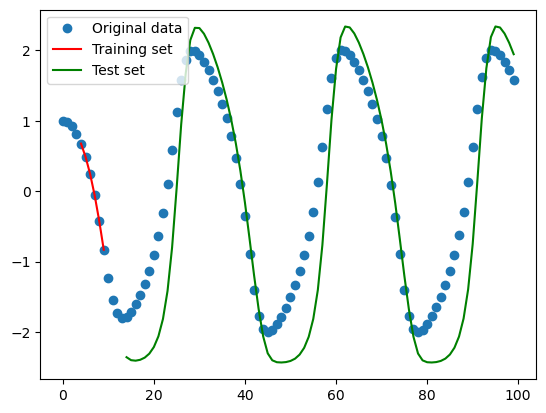

In [56]:
# Plot
plt.plot(timeseries, 'o', label='Original data')
plt.plot(train_plot, c='r', label='Training set')
plt.plot(test_plot, c='g', label='Test set')
plt.legend()
plt.show()